# MORDM - Directed Search over Levers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import changefont as cf

import os 
os.chdir(os.getcwd())
import sys
# insert at 1, 0 is the script path (or '' in REPL)
pydice_folder = os.path.dirname(os.getcwd())+"\\1_Model"
policy_folder = os.path.dirname(os.getcwd())+"\\5_Policy_Discovery"
sys.path.insert(1, pydice_folder)

from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench import (save_results, load_results, Model, Policy, Scenario, 
                           Constraint, RealParameter, IntegerParameter, ScalarOutcome, 
                           MultiprocessingEvaluator, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1
# ema_logging.log_to_stderr(ema_logging.DEBUG)

from PyDICE_V4 import PyDICE

C:\Users\Shajee\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sns.set_context("talk")

In [3]:
f = open("output_scenarioselection.txt", "r")
scenario_txt = f.read()[-26:-6]
scenario_lst = eval(scenario_txt)

In [4]:
# eval('results_'+(str(scenario_lst[0])))
scenario_lst

[102, 354, 467, 473]

In [5]:
results_102 = pd.read_csv("wcs_102.csv", index_col=0)
convergence_102 = pd.read_csv("wcs_con_102.csv", index_col=0)

In [6]:
results_354 = pd.read_csv("wcs_354.csv", index_col=0)
convergence_354 = pd.read_csv("wcs_con_354.csv", index_col=0)

In [7]:
results_467 = pd.read_csv("wcs_467.csv", index_col=0)
convergence_467 = pd.read_csv("wcs_con_467.csv", index_col=0)

In [8]:
results_473 = pd.read_csv("wcs_473.csv", index_col=0)
convergence_473 = pd.read_csv("wcs_con_473.csv", index_col=0)

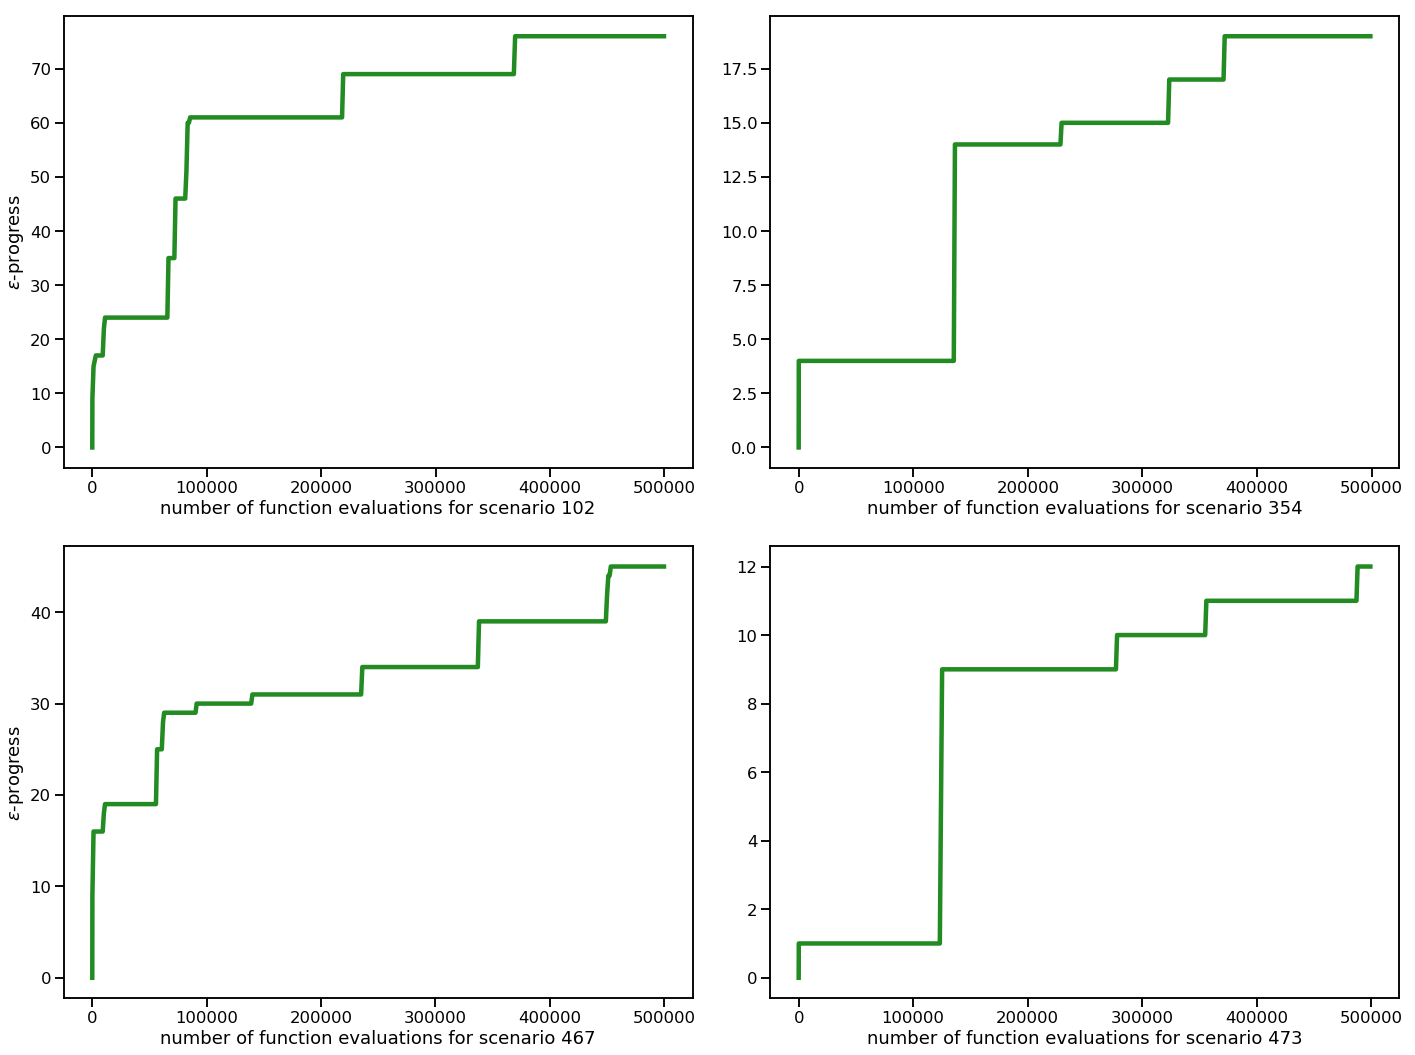

In [9]:
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(20,15))
axes[0,0].plot(convergence_102.nfe, convergence_102.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[0,0].set_ylabel('$\epsilon$-progress')
axes[0,0].set_xlabel('number of function evaluations for scenario 102')

axes[0,1].plot(convergence_354.nfe, convergence_354.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[0,1].set_xlabel('number of function evaluations for scenario 354')

axes[1,0].plot(convergence_467.nfe, convergence_467.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[1,0].set_ylabel('$\epsilon$-progress')
axes[1,0].set_xlabel('number of function evaluations for scenario 467')

axes[1,1].plot(convergence_473.nfe, convergence_473.epsilon_progress, color = "forestgreen", linewidth = 4.5)
axes[1,1].set_xlabel('number of function evaluations for scenario 473')

plt.tight_layout()
fig.savefig("epsilon_convergence_MORDM_V4.png", bbox_inches='tight')
plt.show()

In [10]:
results_102["scenario"] = "scenario 102"
results_354["scenario"] = "scenario 354" 
results_467["scenario"] = "scenario 467" 
results_473["scenario"] = "scenario 473"

In [11]:
results = pd.concat([results_102, results_354, results_467, results_473], ignore_index=True)
results.head()

sr     irstp  periodfullpart  miu_period  \
0  0.262103  0.001813              29          13   
1  0.484353  0.011618              52          11   
2  0.209431  0.001544              54          11   
3  0.260357  0.001023              18          14   
4  0.158858  0.001009              23          14   

   Atmospheric Temperature 2050  Damages 2050  Total Output 2050  \
0                      2.553908      0.568313         197.663823   
1                      2.599317      0.825985         254.407020   
2                      2.482013      0.427398         179.658377   
3                      2.570295      0.591714         197.300564   
4                      2.506609      0.408036         161.099273   

   Atmospheric Temperature 2100  Damages 2100  Total Output 2100  ...  \
0                      3.831226     21.656822         486.598326  ...   
1                      3.571390     17.877310         645.484479  ...   
2                      3.454488     10.052809         454.440540  ...   
3                      3.995695     28.196342         476.924150  ...   
4                      3.855603     18.216976         392.143512  ...   

   Damages 2150  Total Output 2150  Atmospheric Temperature 2200  \
0     16.761779         968.978847                      1.876866   
1      3.009899        1290.425710                      0.020960   
2      6.102809         895.527788                      1.534066   
3     27.566910         949.156620                      2.222893   
4     24.014353         767.291269                      2.635183   

   Damages 2200  Total Output 2200  Atmospheric Temperature 2300  \
0      0.580189        1589.831460                           0.0   
1      0.016723        2071.760851                           0.0   
2      0.143805        1445.738452                           0.0   
3      1.782992        1581.987660                           0.0   
4      4.512699        1275.113927                           0.0   

   Damages 2300  Utility 2300  Total Output 2300      scenario  
0      0.024000  26106.551437        2976.965249  scenario 102  
1      0.023634   4360.322245        2931.549640  scenario 102  
2      0.023908  27329.160065        2965.532862  scenario 102  
3      0.024068  30071.139880        2985.392564  scenario 102  
4      0.023838  29711.960386        2956.890489  scenario 102  

[5 rows x 21 columns]

In [12]:
outcomes = results.iloc[:,4:]

outcomes = outcomes.reindex(sorted(outcomes.columns), axis=1)

experiments = results.iloc[:,:4]

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


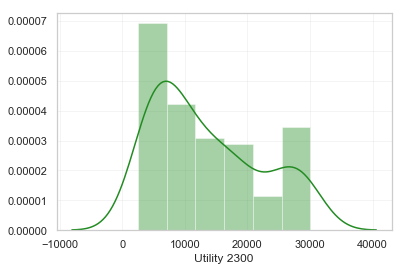

In [13]:
sns.set(context='notebook', style='whitegrid')
sns.distplot(outcomes.iloc[:,-2], color = "forestgreen")
plt.grid(alpha = 0.2)
plt.show()

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
cmap = ListedColormap(sns.color_palette())   

In [15]:
sns.set_context("talk")

In [16]:
clr_palette = ([(0.66,0.66,0.66),sns.color_palette("inferno", 15)[-3],sns.color_palette("YlGn", 10)[-4],
                sns.color_palette("viridis", 10)[3],sns.cubehelix_palette(10)[5]])

In [17]:
results=results.rename(columns = {'sr':'Savings Rate', 'irstp':'Pure Rate of Social Time Preference', 'miu_period':'Emission Control Rate Target'})
resDF = results.copy()
resDF.index = resDF.scenario
resDF = resDF.iloc[:,[0,1,3]]

In [18]:
pollimits = pd.DataFrame({"Savings Rate":[0.1,0.5], 'Pure Rate of Social Time Preference':[0.001, 0.015], 'Emission Control Rate Target':[10, 58]})

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


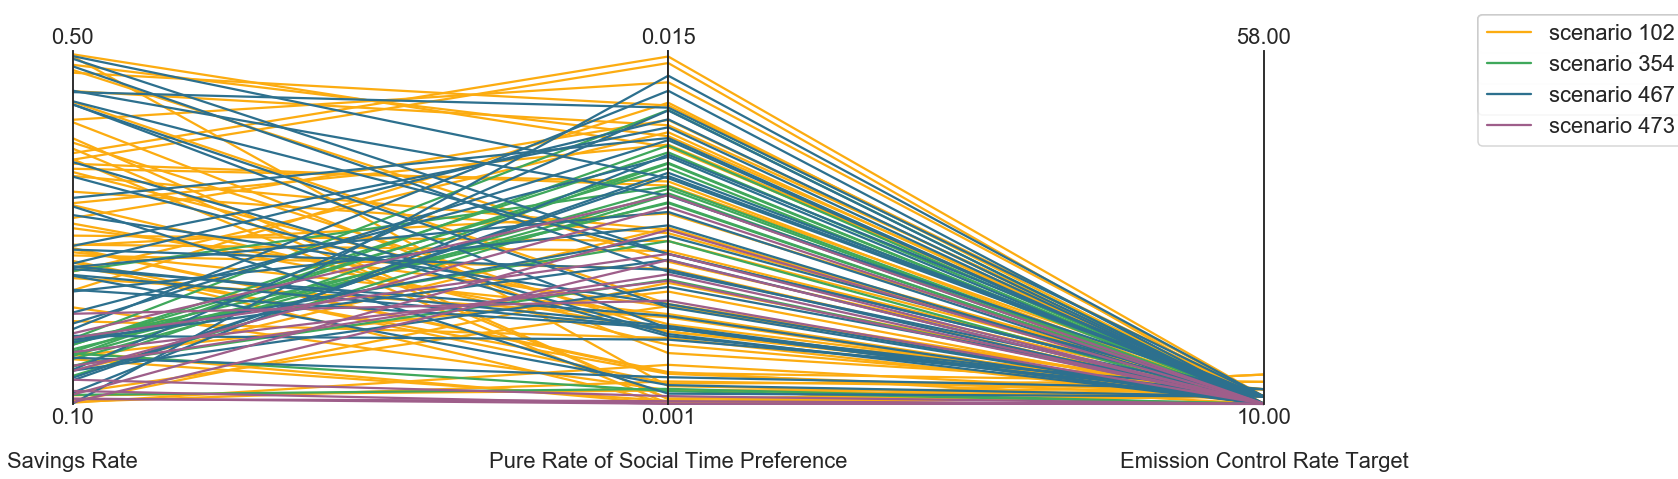

In [19]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for j,k in enumerate(scenario_lst):
    paraxes.plot(resDF[resDF.index == "scenario " + str(k)],
                 color = clr_palette[j+1],
                 label = "scenario " + str(k)
                )
    paraxes.legend()
# cf.change_fontsize(paraxes, fs=24)
paraxes.fig.savefig("plot_policies_V4.png", bbox_inches='tight')
plt.show()

C:\Users\Shajee\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


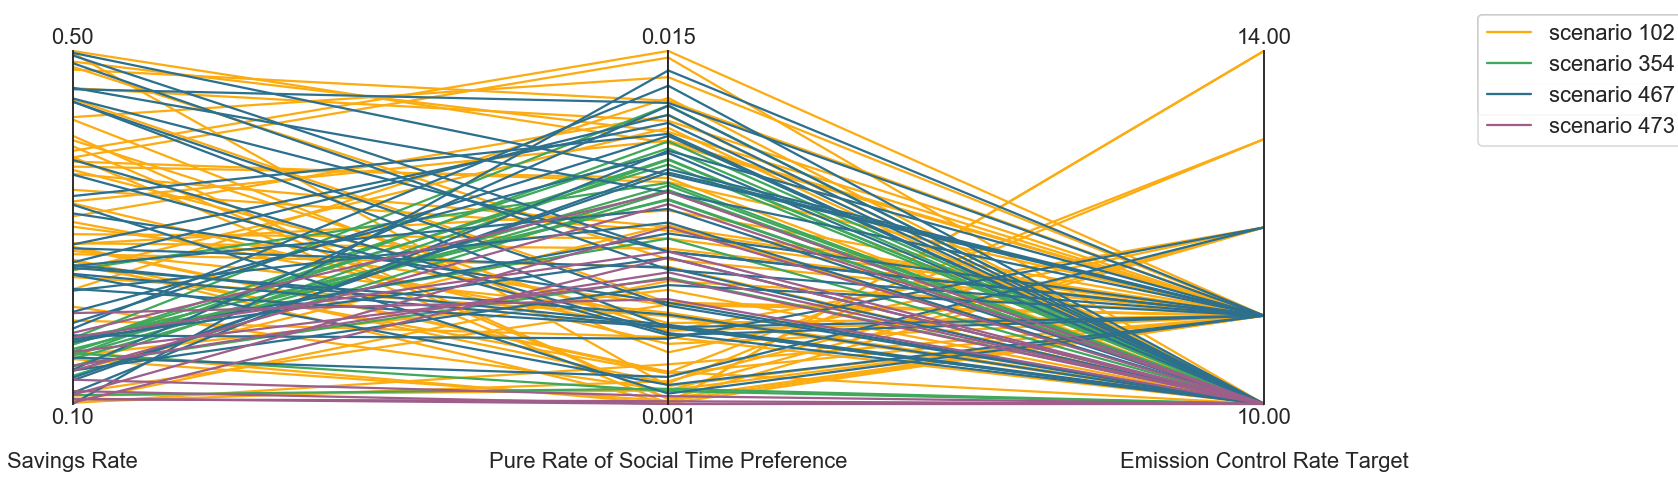

In [20]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(resDF), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for j,k in enumerate(scenario_lst):
    paraxes.plot(resDF[resDF.index == "scenario " + str(k)],
                 color = clr_palette[j+1],
                 label = "scenario " + str(k)
                )
    paraxes.legend()
paraxes.fig.savefig("plot_policies_zoomin_V4.png", bbox_inches='tight')
plt.show()

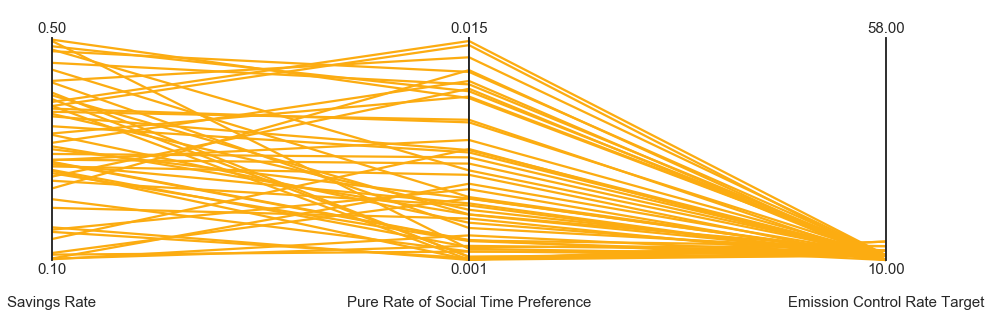

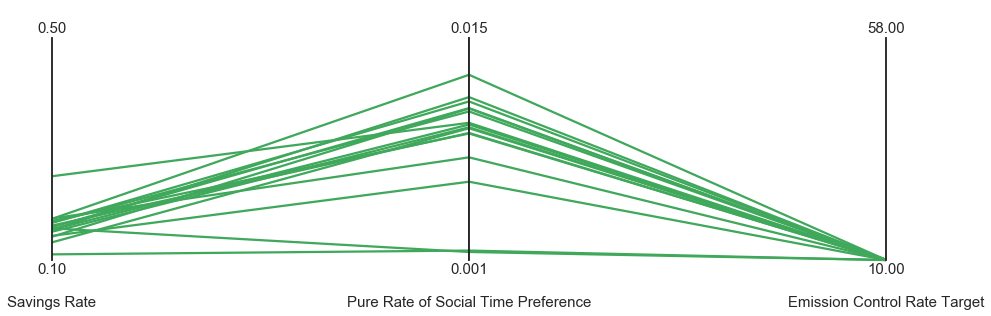

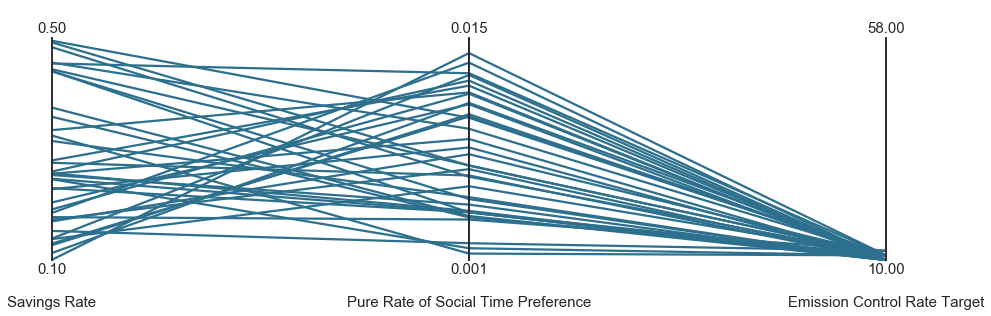

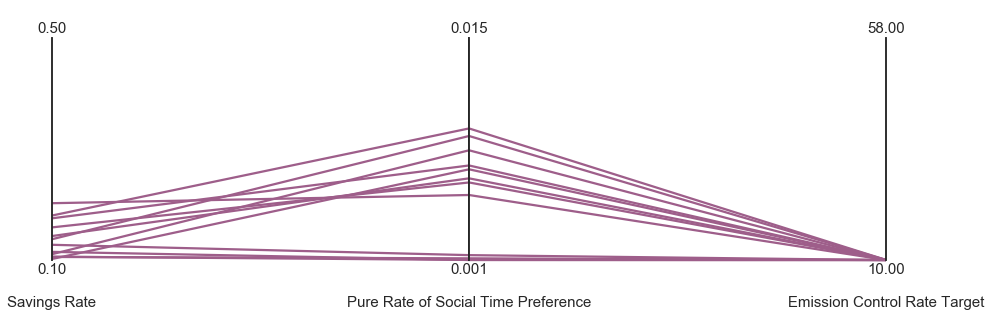

In [21]:
for i,j in enumerate(scenario_lst):
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=15)
    paraxes.fig.set_size_inches(20,5)
    paraxes.plot(results[results.scenario == "scenario " + str(j)].iloc[:,[0,1,3]], color = clr_palette[i+1])
    paraxes.fig.savefig("plot_policies_scenario_" + str(j) + "_V4.png", bbox_inches='tight')
    plt.show()

In [22]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# import pandas as pd 

# data = [
#     go.Parcoords(
#         line = dict(color = experiments["irstp"],
#                    colorscale = 'Jet',
#                    showscale = True,
#                    reversescale = False,
#                    cmin = experiments["irstp"].min(),
#                    cmax = experiments["irstp"].max()),
#         dimensions = list([
#             dict(range = [experiments["sr"].min(),experiments["sr"].max()],
#                  label = 'Savings Rate', values = experiments["sr"]),
#             dict(range = [experiments["irstp"].min(),experiments["irstp"].max()],
#                  label = 'Intitial rate of social time preference', values = experiments["irstp"]),
#             dict(range = [experiments["periodfullpart"].min(),experiments["periodfullpart"].max()],
#                  label = 'Time period at full participation', values = experiments["periodfullpart"]),
#             dict(range = [experiments["miu_period"].min(),experiments["miu_period"].max()],
#                  label = 'Time period until full control rate', values = experiments["miu_period"])
#         ])
#     )
# ]

# py.iplot(data, filename = 'parcoords-dice_sm')

In [23]:
policy_DF = results.iloc[:,[0,1,3,-1]]

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Shajee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Shajee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Shajee\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


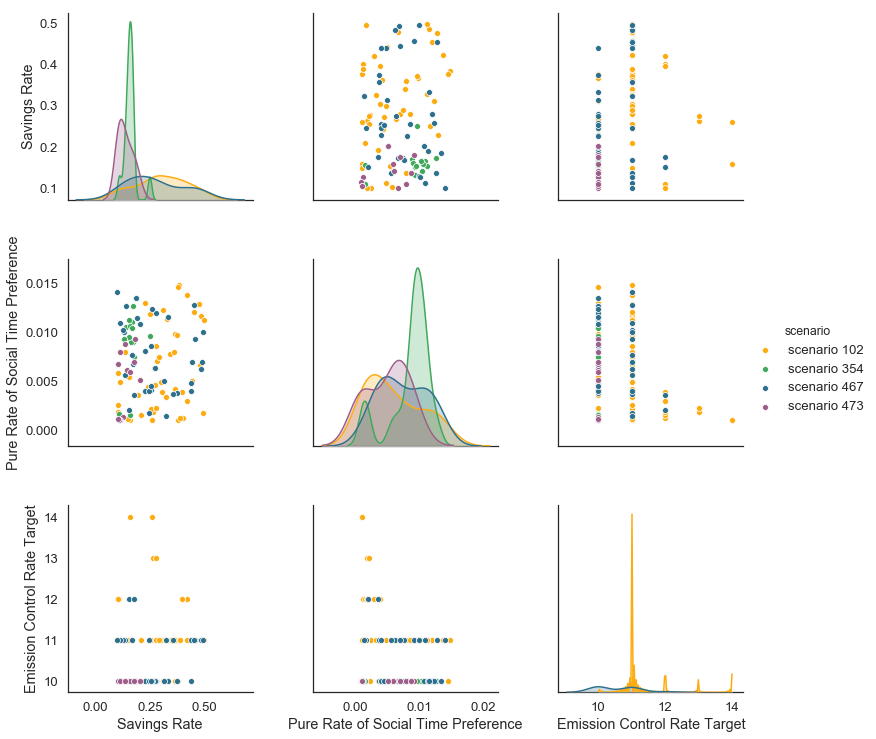

In [24]:
sns.set(font_scale=1.2, style = "white")
pplot_policy = sns.pairplot(data = policy_DF, hue = "scenario", height=3.5, palette=clr_palette[1:5], 
             diag_kind = 'kde')
pplot_policy.savefig("policy_pairplot_V4.png")
plt.show()

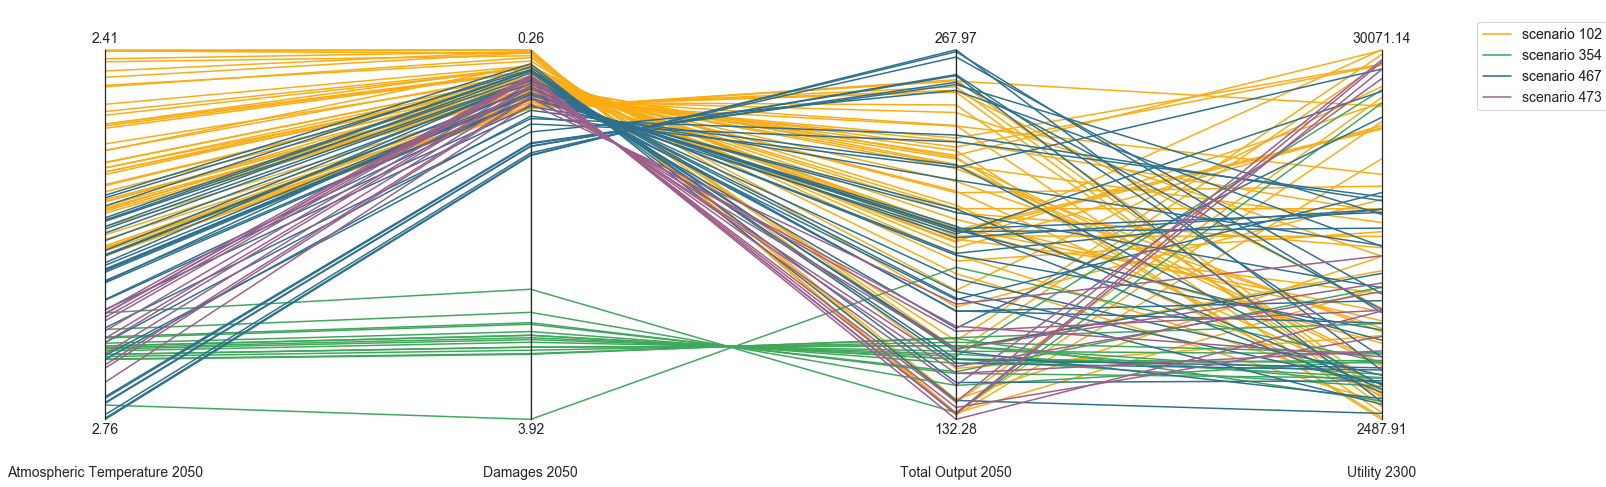

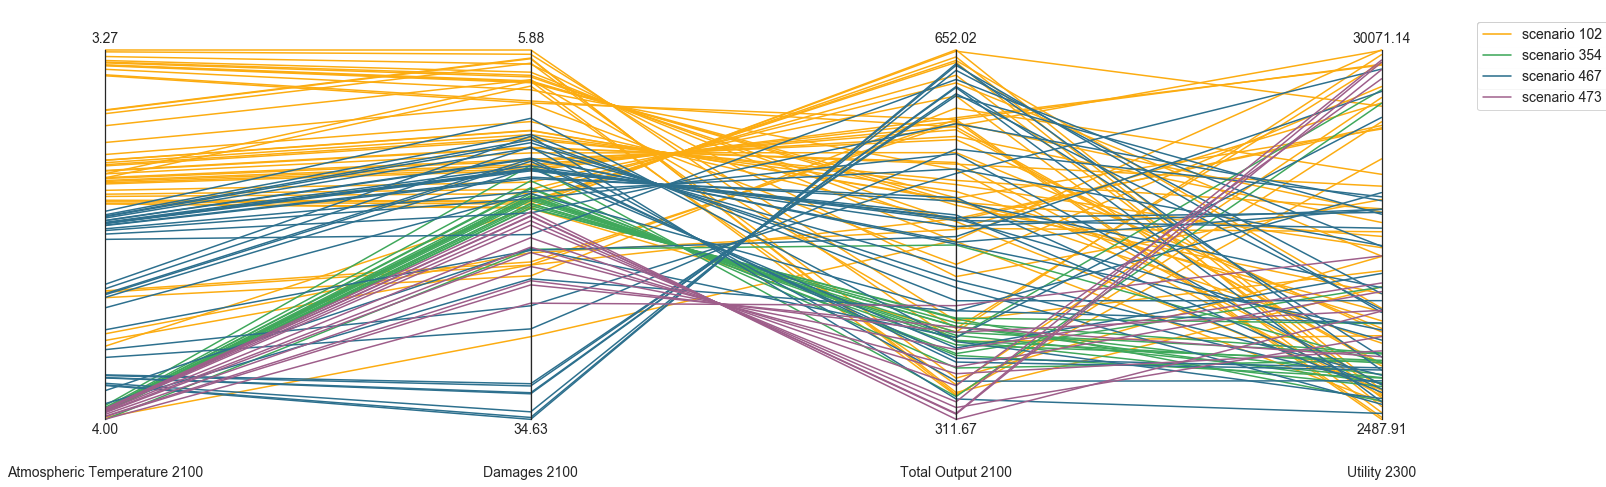

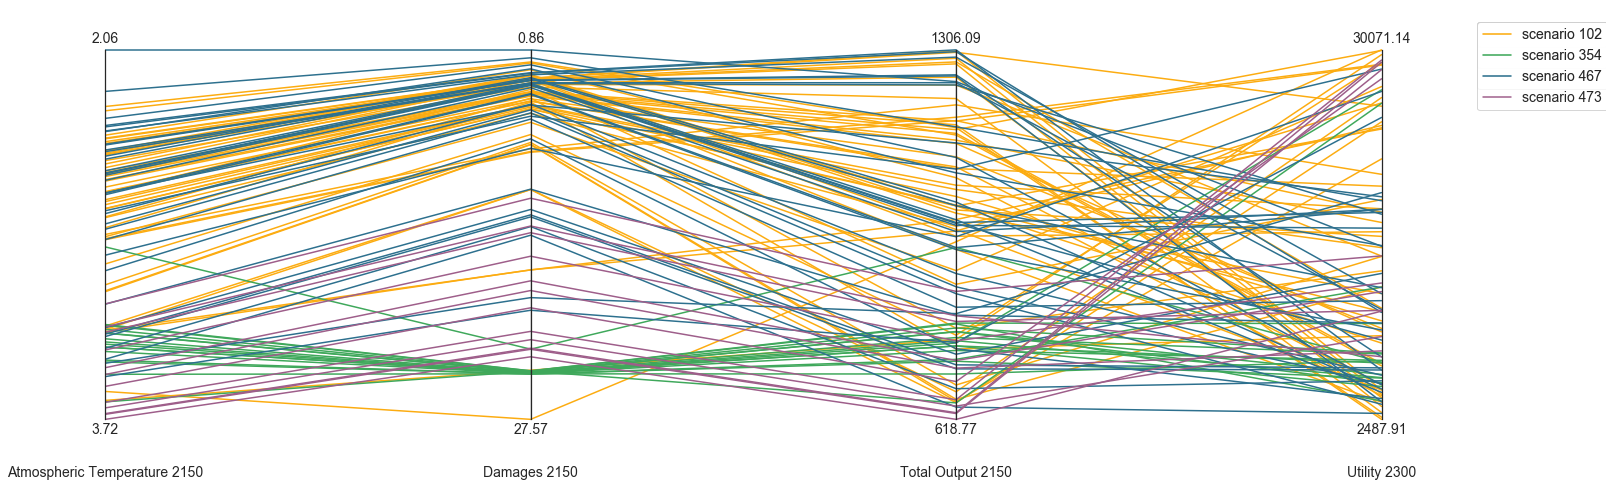

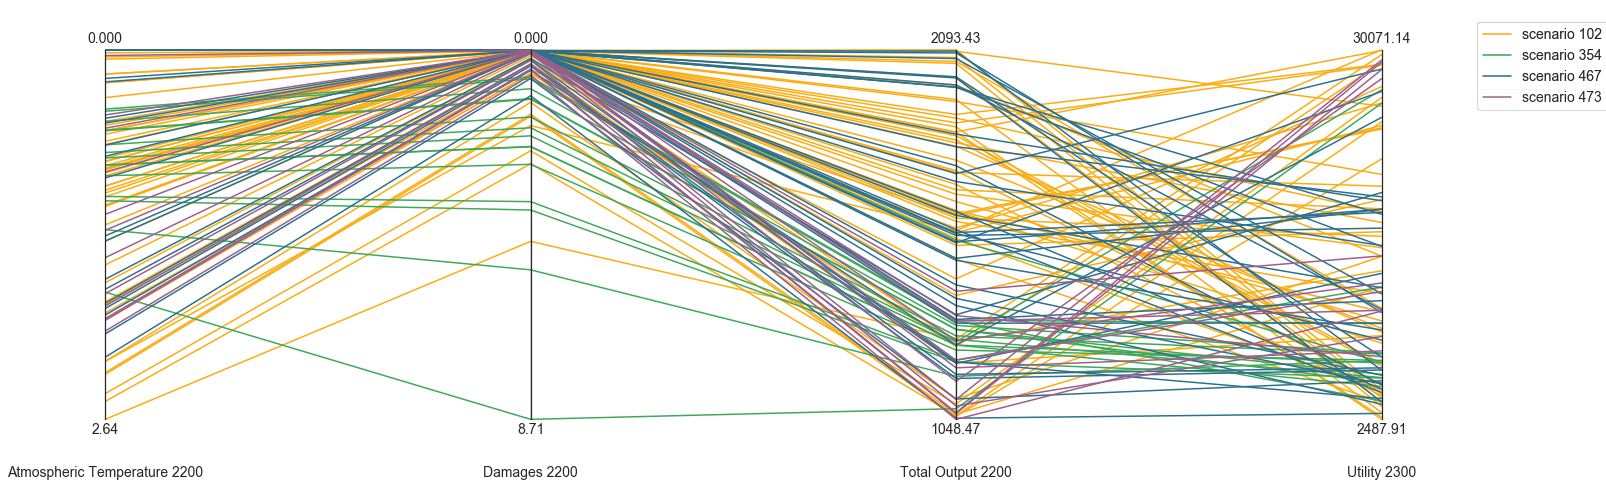

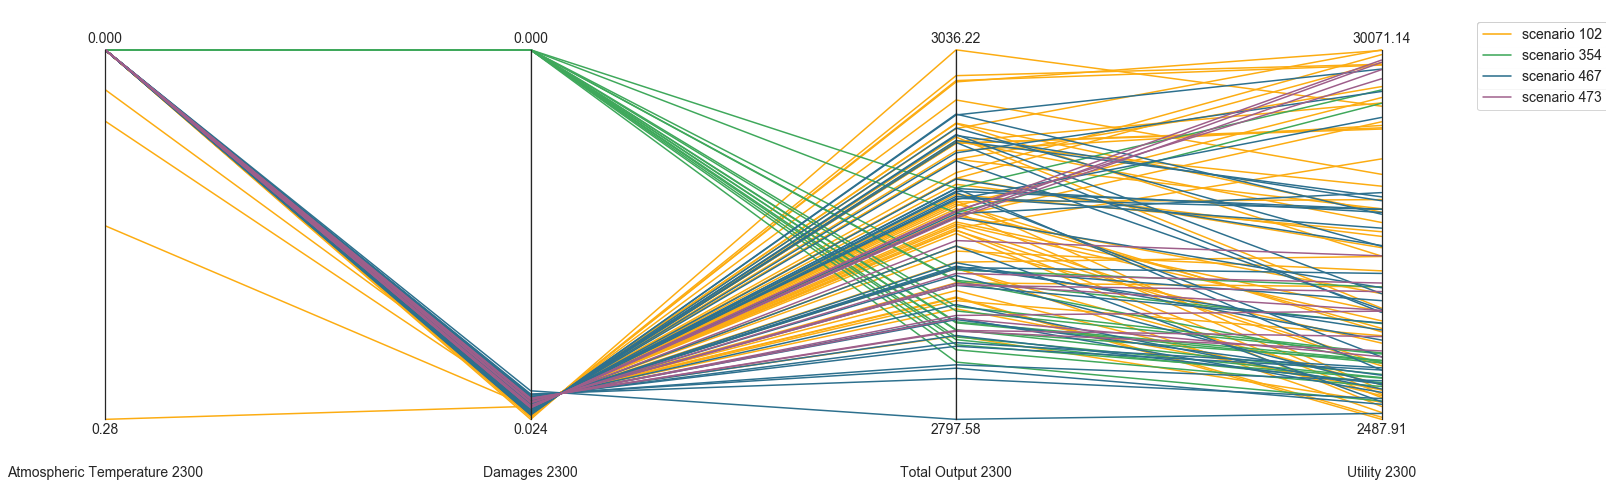

In [25]:
for i in range(int((len(outcomes.columns)-2)/3)):
    outcomes_columns = (list(outcomes.columns[i:-5+i:5]) + 
                          [np.array(outcomes.columns[-2]).tolist()]+[np.array(outcomes.columns[-1]).tolist()])
    outcomes_par = outcomes.loc[:,outcomes_columns]
    outcomes_par.index = outcomes_par.scenario
    del outcomes_par.index.name
    out_par = outcomes_par.iloc[:,:-1]
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(out_par), rot=0)
    paraxes.fig.set_size_inches(20,7)
    for j,k in enumerate(scenario_lst):
        paraxes.plot(out_par[out_par.index == "scenario " + str(k)],
                     color = clr_palette[j+1],
                     label = "scenario " + str(k)
                    )
        paraxes.legend()
    paraxes.invert_axis(outcomes_columns[0:2])
    #plt.gca().legend(('policy 0','policy 1','policy 2','policy 3'), bbox_to_anchor=(1.5, 1), fontsize = 15)
    plt.show()

# Evaluate the robustness of the policies

In [26]:
model = PyDICE()
dice_sm = Model('dicesmEMA', function = model)
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)

In [27]:
dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                         IntegerParameter('t2xco2_dist',0 , 2),
                         IntegerParameter('fdamage', 0, 2),
                         RealParameter('tfp_gr', 0.07, 0.09),
                         RealParameter('sigma_gr', -0.012, -0.008),
                         RealParameter('pop_gr', 0.1, 0.15),
                         RealParameter('fosslim',  4000.0, 13649),
                         IntegerParameter('cback', 100, 600)]

dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                  RealParameter('irstp',  0.001, 0.015),
                  IntegerParameter('periodfullpart', 10, 58),
                  IntegerParameter('miu_period', 10, 58)]

dice_sm.outcomes = [ScalarOutcome('Atmospheric Temperature 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2050', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2050', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2100', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2100', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2150', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2150', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2200', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2200', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2300', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2300', ScalarOutcome.MAXIMIZE)]

In [28]:
policies = results.iloc[:,:4]

In [29]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [30]:
# n_scenarios = 100000
# with MultiprocessingEvaluator(dice_sm, n_processes=8) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)
# save_results(results, 'MORDM_explored_policy_100k_scen_113_pol.tar.gz')

In [31]:
results = load_results('MORDM_explored_policy_100k_scen_113_pol.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Shajee\Documents\GitHub\PyDICE\5_Policy_Discovery\MORDM_explored_policy_100k_scen_113_pol.tar.gz


In [32]:
experiments, outcomes = results

In [33]:
pd.DataFrame(outcomes).describe([0.05, 0.25, 0.50, 0.75, 0.95])

Atmospheric Temperature 2050  Damages 2050  Utility 2050  \
count                  1.130000e+07  1.130000e+07  1.130000e+07   
mean                   1.734435e+00  1.304525e+00 -1.570032e+03   
std                    4.261988e-01  1.208830e+00  2.354107e+02   
min                    1.791122e-01  1.078952e-03 -2.157771e+03   
5%                     8.669308e-01  8.043307e-03 -2.016468e+03   
25%                    1.553282e+00  1.020141e-01 -1.738900e+03   
50%                    1.810530e+00  1.214990e+00 -1.570958e+03   
75%                    2.011555e+00  2.104824e+00 -1.373458e+03   
95%                    2.280725e+00  3.491197e+00 -1.214586e+03   
max                    2.898028e+00  8.945618e+00 -1.079333e+03   

       Total Output 2050  Atmospheric Temperature 2100  Damages 2100  \
count       1.130000e+07                  1.130000e+07  1.130000e+07   
mean        1.904248e+02                  1.715577e+00  3.741487e+00   
std         3.812037e+01                  6.661204e-01  4.541729e+00   
min         1.212660e+02                  4.593736e-02  8.844189e-04   
5%          1.360000e+02                  5.293342e-01  6.499940e-03   
25%         1.576039e+02                  1.313272e+00  2.594504e-01   
50%         1.896987e+02                  1.740979e+00  2.455703e+00   
75%         2.220564e+02                  2.139466e+00  5.540074e+00   
95%         2.543333e+02                  2.762657e+00  1.216152e+01   
max         2.751645e+02                  4.934154e+00  9.814360e+01   

       Utility 2100  Total Output 2100  Atmospheric Temperature 2150  \
count  1.130000e+07       1.130000e+07                  1.130000e+07   
mean   2.008543e+03       4.864333e+02                  6.783090e-01   
std    1.146863e+03       9.980391e+01                  5.778379e-01   
min   -1.425709e+02       2.846639e+02                  0.000000e+00   
5%     3.008786e+02       3.417425e+02                  0.000000e+00   
25%    1.010266e+03       4.008639e+02                  2.108785e-01   
50%    1.873310e+03       4.867207e+02                  5.924764e-01   
75%    2.965681e+03       5.696667e+02                  1.007267e+00   
95%    3.834900e+03       6.532773e+02                  1.729207e+00   
max    4.379373e+03       7.073304e+02                  5.066401e+00   

       Damages 2150  Utility 2150  Total Output 2150  \
count  1.130000e+07  1.130000e+07       1.130000e+07   
mean   1.359407e+00  5.540667e+03       9.540877e+02   
std    3.238052e+00  2.674133e+03       1.959145e+02   
min    0.000000e+00  1.096353e+03       5.406818e+02   
5%     0.000000e+00  1.882293e+03       6.689450e+02   
25%    8.683709e-03  3.143289e+03       7.868343e+02   
50%    1.308773e-01  5.070891e+03       9.612210e+02   
75%    1.427014e+00  7.606089e+03       1.123180e+03   
95%    6.112837e+00  9.945014e+03       1.281974e+03   
max    2.029755e+02  1.084601e+04       1.337988e+03   

       Atmospheric Temperature 2200  Damages 2200  Utility 2200  \
count                  1.130000e+07  1.130000e+07  1.130000e+07   
mean                   5.430824e-02  9.923751e-02  8.644541e+03   
std                    2.008325e-01  9.414556e-01  4.530966e+03   
min                    0.000000e+00  0.000000e+00  1.781518e+03   
5%                     0.000000e+00  0.000000e+00  2.802260e+03   
25%                    0.000000e+00  0.000000e+00  4.576732e+03   
50%                    0.000000e+00  0.000000e+00  7.630252e+03   
75%                    0.000000e+00  1.251114e-02  1.188189e+04   
95%                    3.946136e-01  1.544760e-01  1.643096e+04   
max                    4.430973e+00  1.273395e+02  1.760253e+04   

       Total Output 2200  Atmospheric Temperature 2300  Damages 2300  \
count       1.130000e+07                  1.130000e+07  1.130000e+07   
mean        1.528989e+03                  4.455019e-05  7.997410e-03   
std         3.124286e+02                  5.539342e-03  3.483389e-02   
min         9.451230e+02                

## Robustness Metrics

In [34]:
#import function and settings
from robustness_functions import *
clr_palette = sns.color_palette()

### Signal-To-Noise Ratio

In [35]:
snr_scores = s_to_n(experiments, outcomes, dice_sm.outcomes)

In [47]:
#create another copy
snr_scores_DF = snr_scores.copy()

#drop utility columns besides of 2300
snr_scores_DF = snr_scores_DF.drop(list(snr_scores_DF.columns[-5:-1]), axis = 1)

In [48]:
#normalizing the values between 0 and 1
#snr_scores_DF = snr_scores_DF/snr_scores_DF.max()

In [50]:
snr_scores_DF.iloc[:,:10] = (snr_scores_DF.iloc[:,:10].max() - snr_scores_DF.iloc[:,:10])/snr_scores_DF.iloc[:,:10].max()
snr_scores_DF.iloc[:,10:] = snr_scores_DF.iloc[:,10:]/snr_scores_DF.iloc[:,10:].max()

In [51]:
# for i in range(int(len(snr_scores_DF.columns)/5)):
#     stn_scores_columns = (list(snr_scores_DF.columns[i:-5+i:5]) + 
#                           [np.array(snr_scores_DF.columns[-1]).tolist()])
#     stn_scores_par = snr_scores_DF.loc[:,stn_scores_columns]
#     paraxes = parcoords.ParallelAxes(parcoords.get_limits(stn_scores_par), rot=0)
#     paraxes.fig.set_size_inches(20,7)
#     paraxes.plot(stn_scores_par)
#     #paraxes.invert_axis(stn_scores_columns[0:2])
#     paraxes.legend()
#     plt.show() 

In [52]:
# average snr
snr_scores_DF["Average SNR"] = (snr_scores_DF.iloc[:,:-1].sum(axis=1) + snr_scores_DF.iloc[:,[-1]].sum(axis = 1)*5)/(20)

In [62]:
snr_DF = snr_scores_DF.nlargest(10, "Average SNR")
snr_DF

Atmospheric Temperature 2050  Atmospheric Temperature 2100  \
64                       0.132086                      0.373531   
101                      0.145078                      0.374559   
103                      0.151011                      0.374914   
14                       0.088119                      0.368587   
33                       0.117078                      0.304426   
2                        0.091737                      0.292259   
104                      0.155186                      0.375109   
12                       0.033583                      0.263405   
88                       0.050417                      0.271819   
70                       0.077831                      0.285434   

     Atmospheric Temperature 2150  Atmospheric Temperature 2200  \
64                       0.528650                      0.925160   
101                      0.461863                      0.799342   
103                      0.430079                      0.697866   
14                       0.733005                      0.998165   
33                       0.404781                      0.810017   
2                        0.510531                      0.962380   
104                      0.407126                      0.603309   
12                       0.732056                      0.999282   
88                       0.671793                      0.997721   
70                       0.566378                      0.985379   

     Atmospheric Temperature 2300  Damages 2050  Damages 2100  Damages 2150  \
64                       1.000000      0.735716      0.810995      0.865040   
101                      0.999892      0.785635      0.841448      0.849361   
103                      0.991682      0.806601      0.854772      0.843216   
14                       1.000000      0.521123      0.694456      0.923656   
33                       1.000000      0.730879      0.761957      0.779636   
2                        1.000000      0.620283      0.673961      0.807989   
104                      0.963396      0.820693      0.863934      0.839415   
12                       1.000000      0.272375      0.416450      0.889191   
88                       1.000000      0.388022      0.499555      0.866075   
70                       1.000000      0.549757      0.619737      0.826895   

     Damages 2200  Damages 2300  Total Output 2050  Total Output 2100  \
64       0.963305      0.965397           0.779258           0.998564   
101      0.913790      0.965543           0.781585           0.999351   
103      0.874813      0.955912           0.782808           0.999679   
14       0.998247      0.964805           0.773321           0.995449   
33       0.894326      0.965339           0.868150           0.978893   
2        0.972455      0.965048           0.863538           0.973797   
104      0.838519      0.907938           0.783748           0.999895   
12       0.998917      0.963860           0.855108           0.961372   
88       0.997217      0.964286           0.857375           0.965056   
70       0.987147      0.964867           0.861333           0.970908   

     Total Output 2150  Total Output 2200  Total Output 2300  Utility 2300  \
64            0.929432           0.987913           0.997734      0.942140   
101           0.911710           0.975344           0.998995      0.957291   
103           0.902732           0.966282           0.999590      0.983193   
14            0.973398           0.999414           0.993197      0.881883   
33            0.885976           0.970803           0.998062      0.983179   
2             0.914323           0.990323           0.995715      0.947391   
104           0.896046           0.958163           0.999981      0.981720   
12            0.962328           0.999726           0.989909      0.994380   
88            0.950597           0.998985           0.991649      0.959775   
70            0.927801           0.995045           0.994373      0.930580 

In [63]:
#snr_DF = snr_scores_DF[stn_scores.iloc[:,-1] > stn_scores.iloc[:,-1].quantile(0.95)]

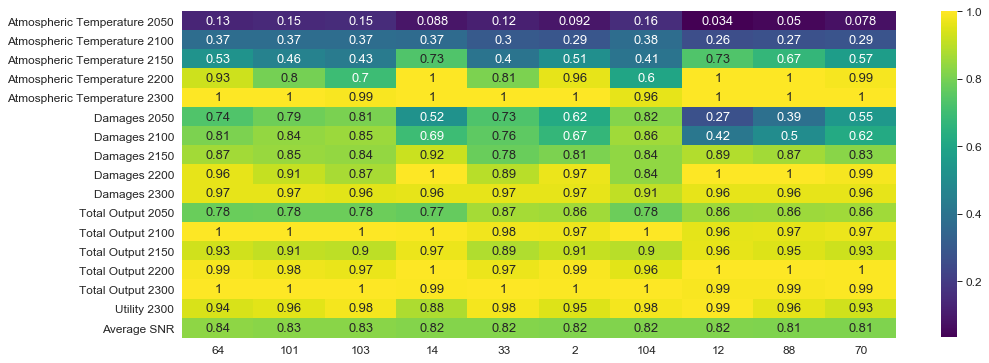

In [64]:
sns.set_context("paper", 1.35)
plt.figure(figsize=(16, 6))
sns.heatmap((snr_DF).T, cmap='viridis', annot=True)
plt.savefig("heatmap_snr_outcome_V4.png",bbox_inches ="tight")
plt.show()

In [65]:
snr_polDF = experiments[experiments.policy.
                       isin(list(snr_DF.index.values))].loc[:,['sr', 'irstp', 'periodfullpart', 'miu_period']].drop_duplicates()

snr_polDF.index = ((snr_polDF.index)/100000).astype(int)
snr_polDF.columns = ["Savings Rate","Pure Rate of Social Time Preference", "Full Participation Target", "Emission Control Rate Target"]

snr_polDF = snr_polDF.drop(["Full Participation Target"],axis=1)

In [66]:
pollimits = pd.DataFrame({"Savings Rate":[0.1,0.5], 'Pure Rate of Social Time Preference':[0.001, 0.015], 'Emission Control Rate Target':[10, 58]})

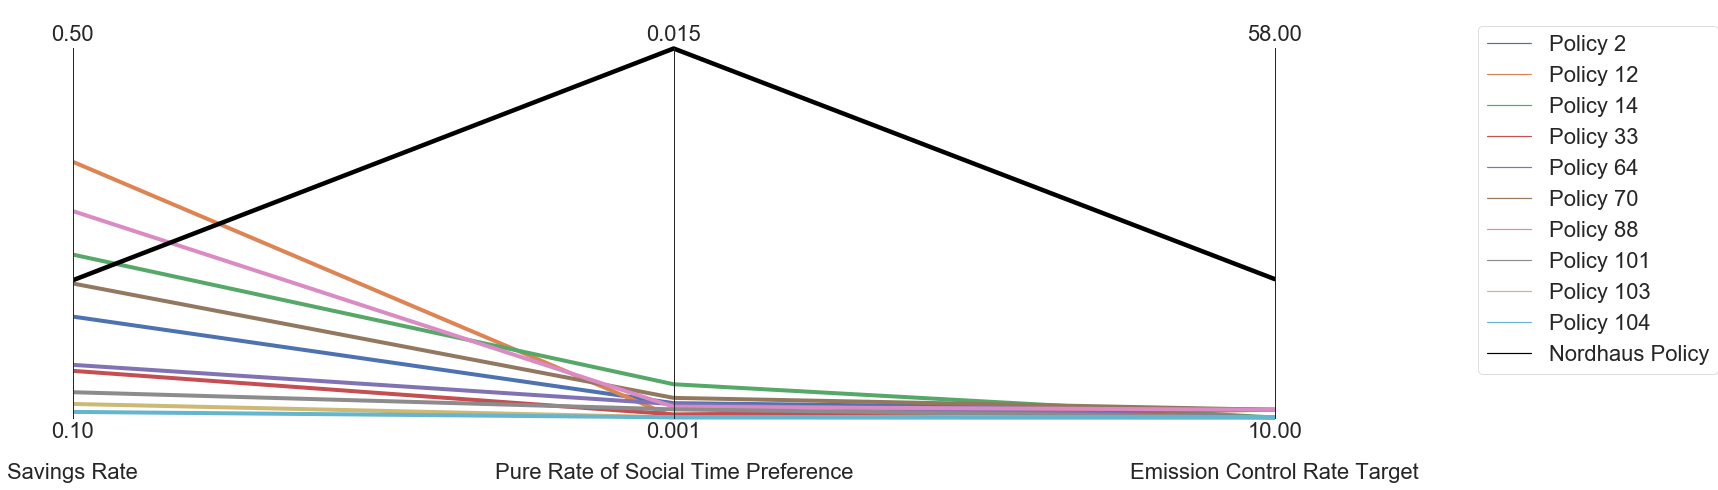

In [67]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for i in range (len(snr_polDF)):
    paraxes.plot(snr_polDF.iloc[[i],:],
                 linewidth=4,
                 color = clr_palette[i],
                 label = ("Policy "+str(snr_polDF.index.tolist()[i])))
paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = snr_polDF.columns).T, 
             color = 'black',
             linewidth=4.5,
             label = 'Nordhaus Policy')
paraxes.legend()
paraxes.fig.savefig("snr_plot_policies_V4.png", bbox_inches='tight')
plt.show() 

<function matplotlib.pyplot.show(*args, **kw)>

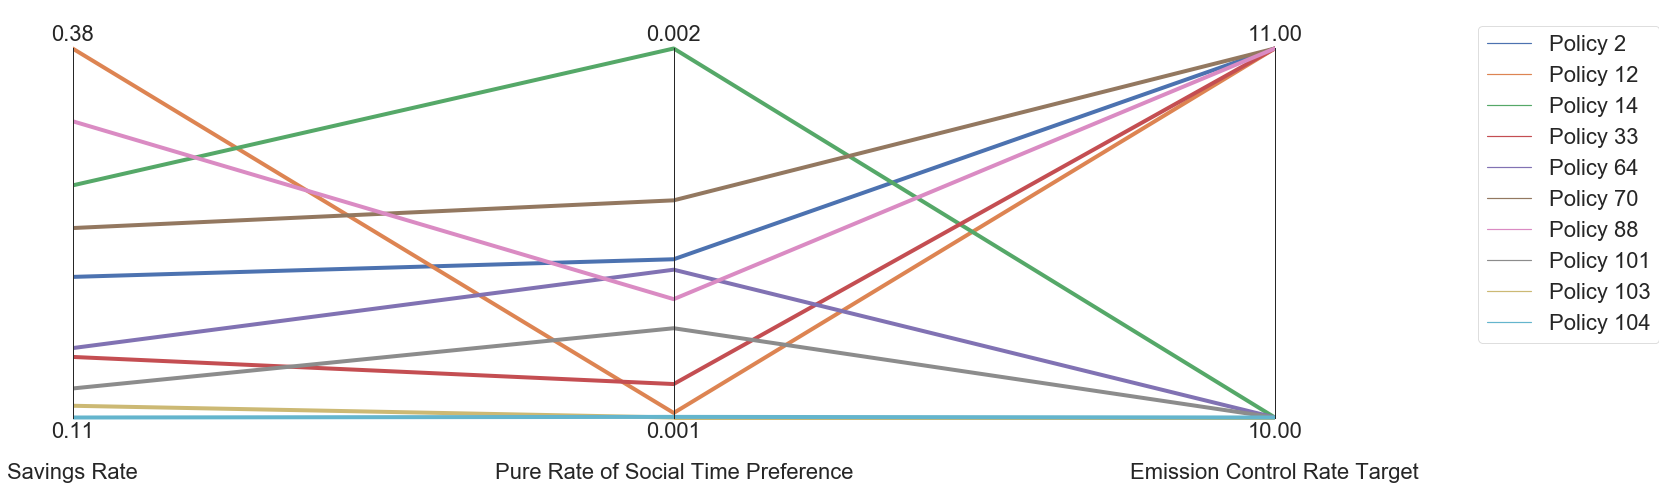

In [68]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(snr_polDF), rot=0, fontsize=22)
paraxes.fig.set_size_inches(20,7)
for i in range (len(snr_polDF)):
    paraxes.plot(snr_polDF.iloc[[i],:],
                 linewidth=4,
                 color = clr_palette[i],
                 label = ("Policy "+str(snr_polDF.index.tolist()[i])))
paraxes.legend()
paraxes.fig.savefig("snr_regret_plot_policies_V4_wo_Nord.png", bbox_inches='tight')
plt.show

### Minimax regret

In [69]:
max_regret, overall_regret = max_regret(experiments, outcomes, dice_sm.outcomes)
# max_regret_w_util = max_regret.copy()

In [119]:
max_regret_DF = max_regret.copy()

In [120]:
#drop utility columns besides of 2300
max_regret_DF = max_regret_DF.drop(list(max_regret_DF.columns[2:-3:4]), axis = 1)

# normalisation of the maximum regret
max_regret_DF = max_regret_DF.reindex(sorted(max_regret_DF.columns), axis=1)
maxregretDF = (max_regret_DF/max_regret_DF.max())

# average maximum regret
#maxregretDF["average_max_regret"] = maxregretDF.mean(axis = 1)
maxregretDF["average_max_regret"] = (maxregretDF.iloc[:,:-1].sum(axis=1) + maxregretDF.iloc[:,[-1]].sum(axis = 1)*5)/(20)

Index(['Utility 2300'], dtype='object')


In [121]:
maxregDF = maxregretDF.nsmallest(10, 'average_max_regret')
#maxregDF[maxregretDF.iloc[:,-1] < maxregretDF.iloc[:,-1].quantile(0.10)]

In [122]:
maxregDF = maxregDF.sort_index()

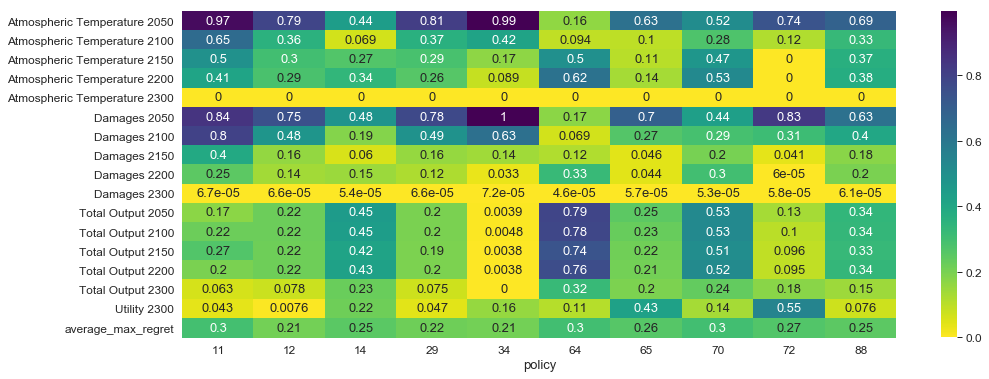

In [123]:
sns.set(context = "paper", font_scale = 1.35)
plt.figure(figsize=(16, 6))
hmp_maxreg = sns.heatmap((maxregDF).T, cmap='viridis_r', annot=True)
plt.savefig("heatmap_max_regret_outcome_V4.png",bbox_inches ="tight")
plt.show()

In [124]:
max_reg_wo_avgDF = maxregDF.drop(["average_max_regret"], axis = 1)

In [125]:
max_reg_wo_avgDF = max_reg_wo_avgDF.sort_index(axis=1)

In [126]:
len(max_reg_wo_avgDF.columns)/4

4.0

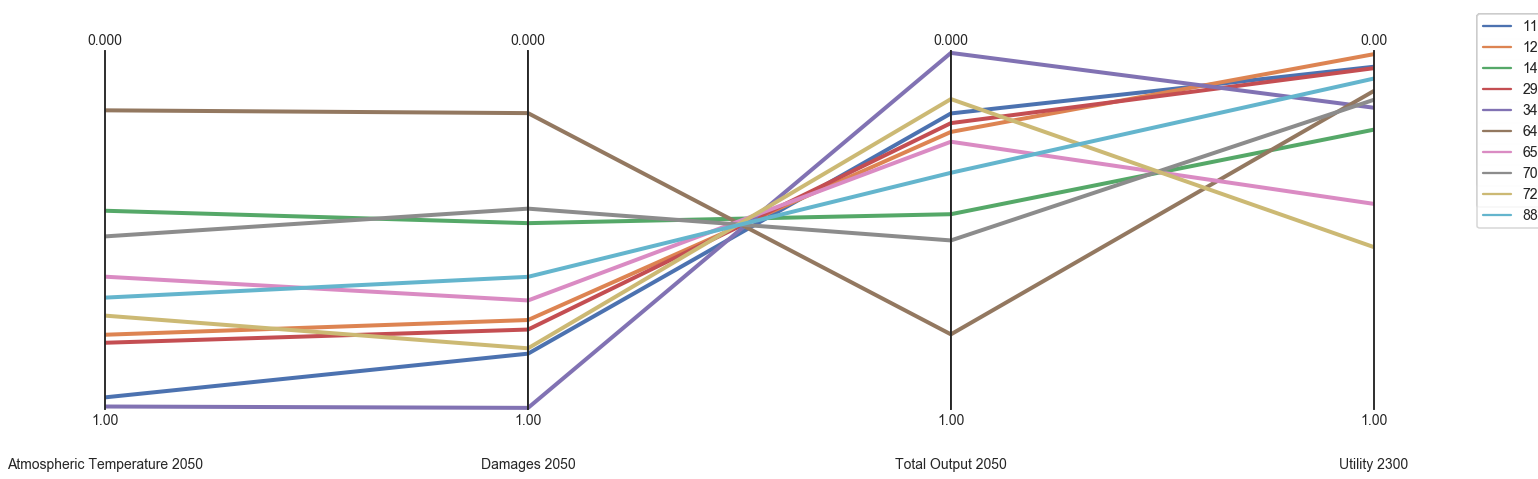

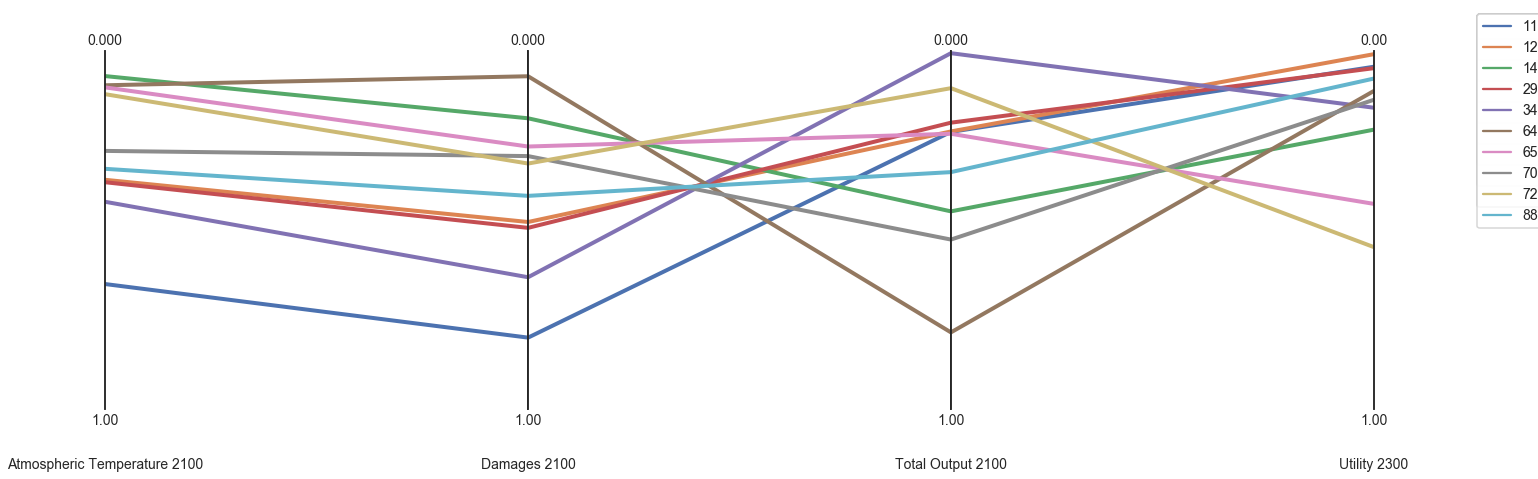

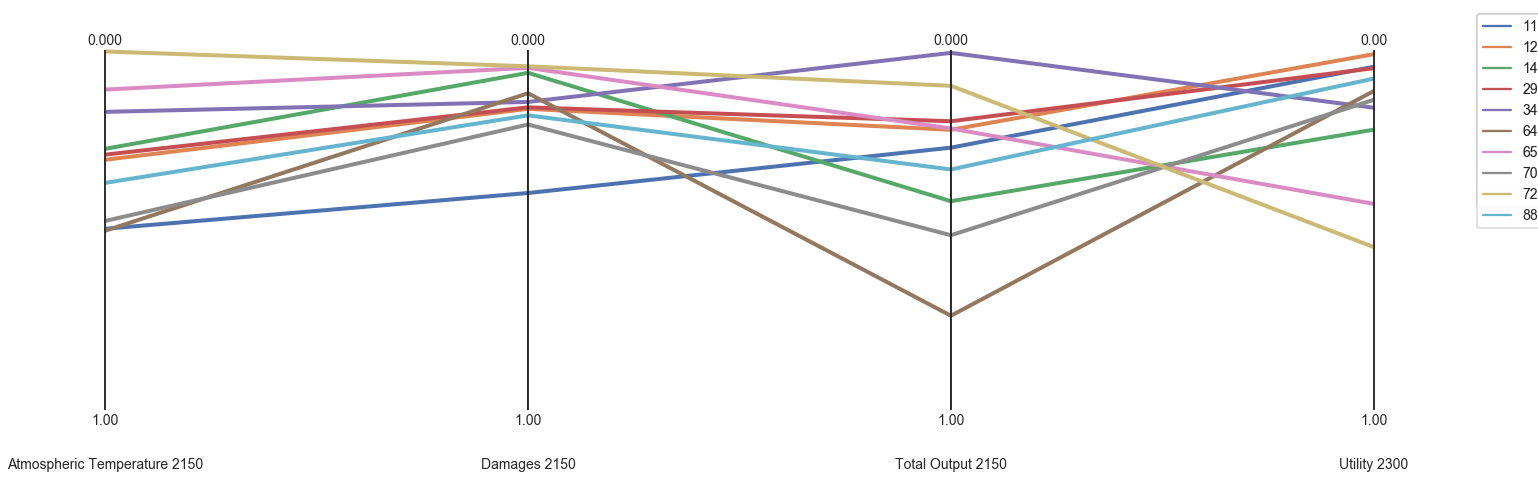

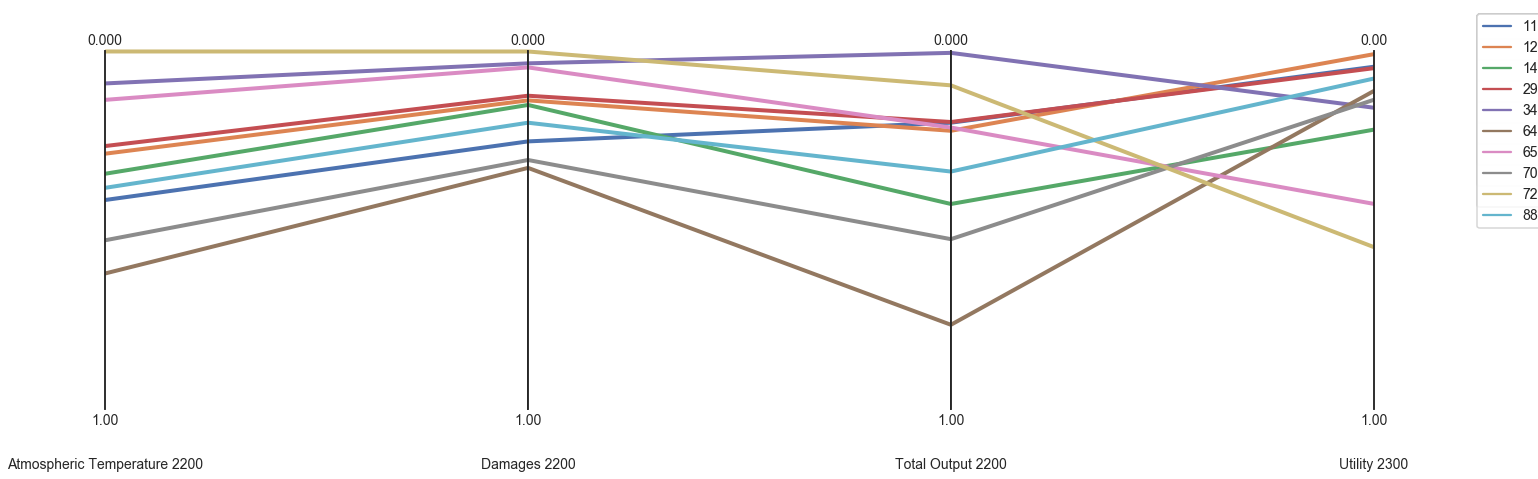

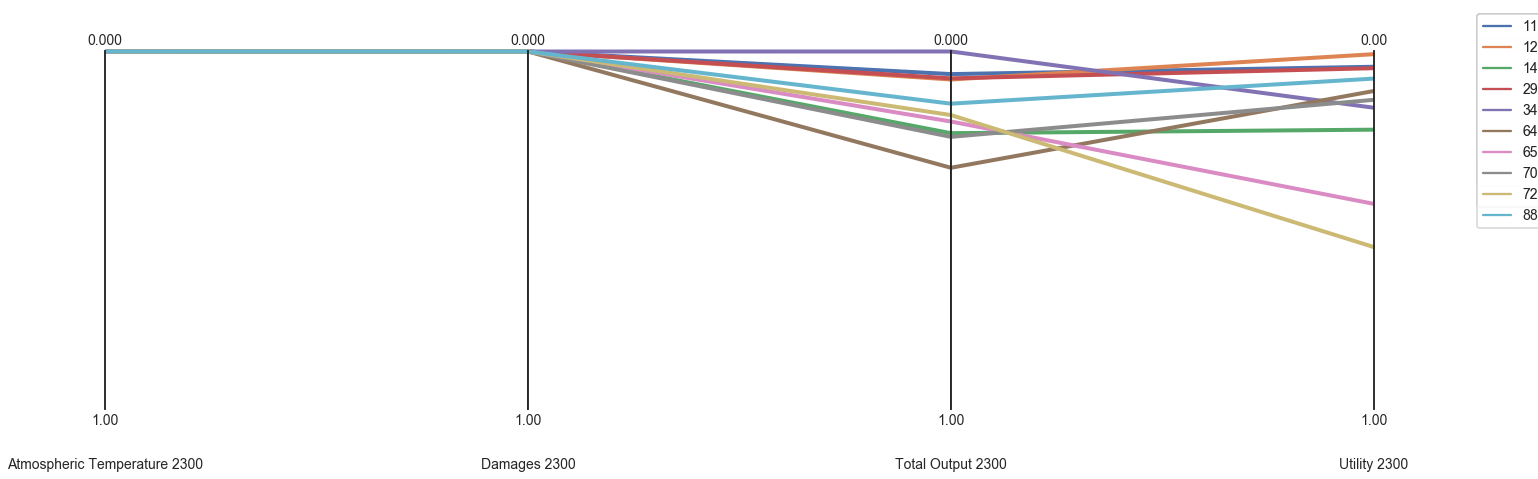

In [127]:
for i in range(int(len(max_reg_wo_avgDF.columns)/4)+1):
    sns.set_context("talk")
    max_scores_columns = (list(max_reg_wo_avgDF.columns[i:15:5]) + 
                          [np.array(max_reg_wo_avgDF.columns[-1]).tolist()])
    max_scores_par = max_reg_wo_avgDF.loc[:,max_scores_columns]
    max_scores_limits = pd.DataFrame(np.array([[0, 0, 0, 0],[1, 1, 1, 1]]), columns = max_scores_columns)
    paraxes = parcoords.ParallelAxes(parcoords.get_limits(max_scores_limits), rot=0)
    paraxes.fig.set_size_inches(20,7)
    for j in range (int(len(max_scores_par.index.tolist()))):   
        paraxes.plot(max_scores_par.iloc[[j],:], 
                     linewidth=4,
                     color = clr_palette[j],
                     label = max_scores_par.index.tolist()[j])
        paraxes.legend()
    paraxes.invert_axis(max_scores_columns)
    paraxes.fig.savefig("max_regret_plot_"+max_reg_wo_avgDF.columns[i][-4:]+".png", bbox_inches='tight')
    plt.show() 

In [128]:
robpolDF = experiments[experiments.policy.
                       isin(list(maxregDF.index.values))].loc[:,['sr', 'irstp', 'periodfullpart', 'miu_period']].drop_duplicates()

In [129]:
robpolDF = robpolDF.reset_index(drop=True)

In [130]:
robpolDF.columns = ["Savings Rate","Pure Rate of Social Time Preference", "Full Participation Target", "Emission Control Rate Target"]

In [131]:
# robpolDF_columns=["sr","irstp", "miu_period", "periodfullpart"]
# robpolDF=robpolDF.reindex(columns=robpolDF_columns)

In [132]:
robpolDF = robpolDF.drop(["Full Participation Target"],axis=1)

In [133]:
robpolDF = robpolDF.set_index(pd.Index(max_scores_par.index.tolist()))

In [134]:
robpolDF

Savings Rate  Pure Rate of Social Time Preference  \
11      0.401193                             0.001188   
12      0.377313                             0.001020   
14      0.276679                             0.002262   
29      0.389462                             0.001215   
34      0.494000                             0.001705   
64      0.157100                             0.001508   
65      0.374155                             0.003770   
70      0.245337                             0.001744   
72      0.439394                             0.004838   
88      0.323865                             0.001408   

    Emission Control Rate Target  
11                          12.0  
12                          11.0  
14                          10.0  
29                          11.0  
34                          11.0  
64                          10.0  
65                          10.0  
70                          11.0  
72                          10.0  
88                          11.0

In [135]:
pollimits = pd.DataFrame({"Savings Rate":[0.1,0.5], 'Pure Rate of Social Time Preference':[0.001, 0.015], 'Emission Control Rate Target':[10, 58]})

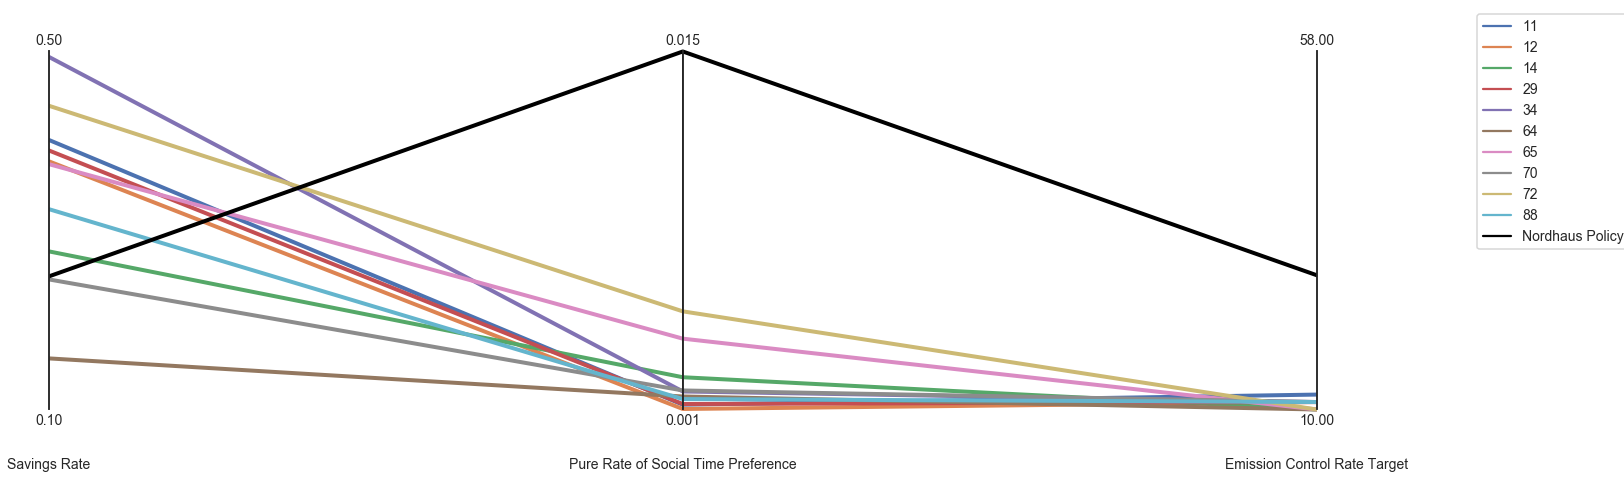

In [136]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(pollimits), rot=0)
paraxes.fig.set_size_inches(20,7)
for j in range (int(len(robpolDF.index.tolist()))):   
    paraxes.plot(robpolDF.iloc[[j],:], 
                 linewidth=4,
                 color = clr_palette[j],
                 label = robpolDF.index.tolist()[j])
paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
             color = 'black',
             linewidth=4,
             label = 'Nordhaus Policy')
#plt.gca().legend(bbox_to_anchor=(1.4, 1), fontsize = 15)
#paraxes.invert_axis(stn_scores_columns)
paraxes.legend()
paraxes.fig.savefig("max_regret_plot_policies_V4.png", bbox_inches='tight')
plt.show() 

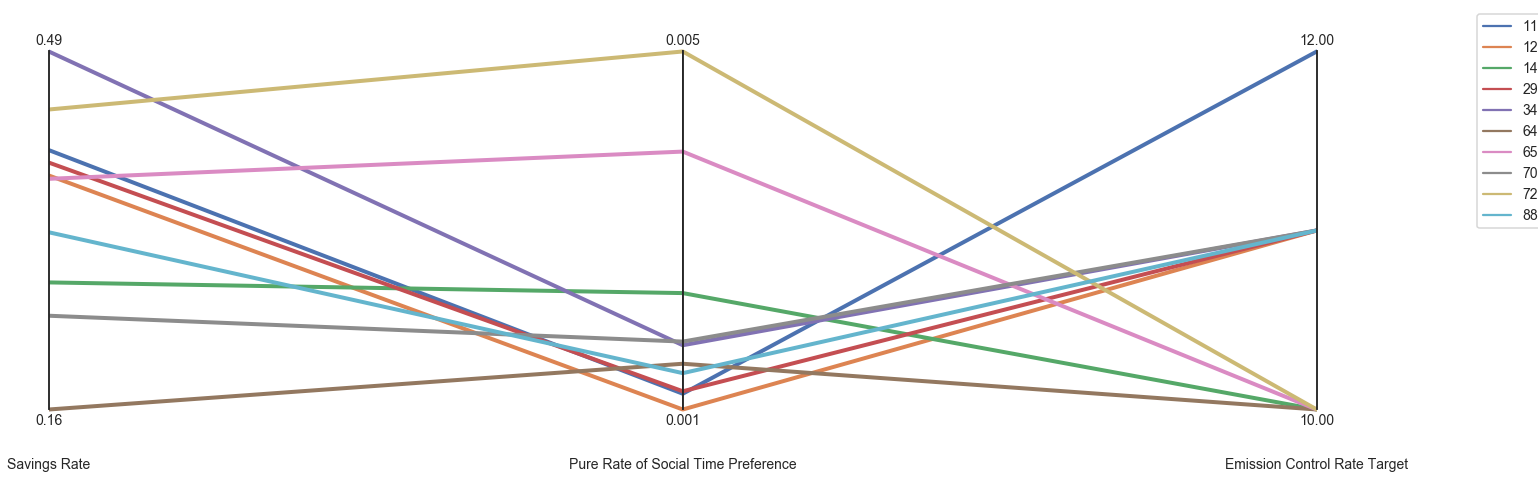

In [137]:
paraxes = parcoords.ParallelAxes(parcoords.get_limits(robpolDF), rot=0)
paraxes.fig.set_size_inches(20,7)
for j in range (int(len(robpolDF.index.tolist()))):   
    paraxes.plot(robpolDF.iloc[[j],:], 
                 linewidth=4,
                 color = clr_palette[j],
                 label = robpolDF.index.tolist()[j])
# paraxes.plot(pd.DataFrame([np.mean(dice_opt.iloc[129]),0.015,28], index = robpolDF.columns).T, 
#              color = 'black',
#              linewidth=4,
#              label = 'Nordhaus Policy')
#plt.gca().legend(bbox_to_anchor=(1.4, 1), fontsize = 15)
#paraxes.invert_axis(stn_scores_columns)
paraxes.legend()
paraxes.fig.savefig("max_regret_plot_policies_V4_wo_Nord.png", bbox_inches='tight')
plt.show() 